# Deploying yolort on TensorRT

Unlike other pipelines that deal with yolov5 on TensorRT, we embed the whole post-processing into the Graph with `onnx-graghsurgeon`. We gain a lot with this whole pipeline. The ablation experiment results are below. The first one is the result without running `EfficientNMS_TRT`, and the second one is the result with `EfficientNMS_TRT` embedded. As you can see, the inference time is even reduced, we guess it is because the data copied to the device will be much less after doing `EfficientNMS_TRT`. (The mean Latency of D2H is reduced from `0.868048 ms` to `0.0102295 ms`, running on Nivdia Geforce GTX 1080ti, using TensorRT 8.2 with yolov5n6 and scaling images to `512x640`.)

And `onnx-graphsurgeon` is easy to install, you can just use their prebuilt wheels:

```
python3 -m pip install onnx_graphsurgeon --index-url https://pypi.ngc.nvidia.com
```

The detailed results:

```
[I] === Performance summary w/o EfficientNMS_TRT plugin ===
[I] Throughput: 383.298 qps
[I] Latency: min = 3.66479 ms, max = 5.41199 ms, mean = 4.00543 ms, median = 3.99316 ms, percentile(99%) = 4.23831 ms
[I] End-to-End Host Latency: min = 3.76599 ms, max = 6.45874 ms, mean = 5.08597 ms, median = 5.07544 ms, percentile(99%) = 5.50839 ms
[I] Enqueue Time: min = 0.743408 ms, max = 5.27966 ms, mean = 0.940805 ms, median = 0.924805 ms, percentile(99%) = 1.37329 ms
[I] H2D Latency: min = 0.502045 ms, max = 0.62674 ms, mean = 0.538255 ms, median = 0.537354 ms, percentile(99%) = 0.582153 ms
[I] GPU Compute Time: min = 2.23233 ms, max = 3.92395 ms, mean = 2.59913 ms, median = 2.58661 ms, percentile(99%) = 2.8201 ms
[I] D2H Latency: min = 0.851807 ms, max = 0.900421 ms, mean = 0.868048 ms, median = 0.867676 ms, percentile(99%) = 0.889191 ms
[I] Total Host Walltime: 3.0081 s
[I] Total GPU Compute Time: 2.99679 s
[I] Explanations of the performance metrics are printed in the verbose logs.
[I]
&&&& PASSED TensorRT.trtexec [TensorRT v8201] # trtexec --onnx=yolov5n6-no-nms.onnx --workspace=8096
```

```
[I] === Performance summary w/ EfficientNMS_TRT plugin ===
[I] Throughput: 389.234 qps
[I] Latency: min = 2.81482 ms, max = 9.77234 ms, mean = 3.1062 ms, median = 3.07642 ms, percentile(99%) = 3.33548 ms
[I] End-to-End Host Latency: min = 2.82202 ms, max = 11.6749 ms, mean = 4.939 ms, median = 4.95587 ms, percentile(99%) = 5.45207 ms
[I] Enqueue Time: min = 0.999878 ms, max = 11.3833 ms, mean = 1.28942 ms, median = 1.18579 ms, percentile(99%) = 4.53088 ms
[I] H2D Latency: min = 0.488159 ms, max = 0.633881 ms, mean = 0.546754 ms, median = 0.546631 ms, percentile(99%) = 0.570557 ms
[I] GPU Compute Time: min = 2.30298 ms, max = 9.21094 ms, mean = 2.54921 ms, median = 2.51904 ms, percentile(99%) = 2.78528 ms
[I] D2H Latency: min = 0.00610352 ms, max = 0.302734 ms, mean = 0.0102295 ms, median = 0.00976562 ms, percentile(99%) = 0.0151367 ms
[I] Total Host Walltime: 3.00591 s
[I] Total GPU Compute Time: 2.98258 s
[I] Explanations of the performance metrics are printed in the verbose logs.
[I]
&&&& PASSED TensorRT.trtexec [TensorRT v8201] # trtexec --onnx=yolov5n6-efficient-nms.onnx --workspace=8096
```

In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

assert torch.cuda.is_available()
device = torch.device('cuda')

print(f"We're using: {device}:{os.environ['CUDA_VISIBLE_DEVICES']}.")

We're using: cuda:0.


In [2]:
import cv2
import numpy as np

from yolort.utils import cv2_imshow, get_image_from_url, read_image_to_tensor
from yolort.utils.image_utils import plot_one_box, color_list
from yolort.v5 import letterbox, non_max_suppression, scale_coords, attempt_download
from yolort.v5.utils.torch_utils import select_device, time_sync

## Prepare image and model weights to test

In [3]:
# Define some parameters
img_size = 640
stride = 64
fixed_shape = True
score_thresh = 0.35
iou_thresh = 0.45
detections_per_img = 100
precision = "fp32"  # Currently only supports fp32

In [4]:
# yolov5s6.pt is downloaded from 'https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5n6.pt'
model_path = "yolov5n6.pt"

checkpoint_path = attempt_download(model_path)
onnx_path = "yolov5n6.onnx"
engine_path = "yolov5n6.engine"

In [5]:
img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/bus.jpg"
# img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/zidane.jpg"
img_raw = get_image_from_url(img_source)

### Pre Processing

In [6]:
# Preprocess
auto = not fixed_shape
image = letterbox(img_raw, new_shape=(img_size, img_size), stride=stride, auto=auto)[0]
image = read_image_to_tensor(image)
image = image[None]
image = image.to(device)
image = image.contiguous()

In [7]:
image.shape

torch.Size([1, 3, 640, 640])

## Export to ONNX and TensorRT model

Define the YOLOTRTModule for TensorRT inferencing.

In [8]:
from yolort.runtime.yolo_graphsurgeon import YOLOGraphSurgeon

In [9]:
yolo_gs = YOLOGraphSurgeon(model_path, version="r6.0", input_sample=image)


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

[W] 'Shape tensor cast elision' routine failed with: None


You can comment out the following block if you do not want to register the `EfficientNMS_TRT` into the graph.

In [10]:
yolo_gs.register_nms(
    score_thresh=score_thresh,
    nms_thresh=iou_thresh,
    detections_per_img=detections_per_img,
)

Created NMS plugin 'EfficientNMS_TRT' with attributes: {'plugin_version': '1', 'background_class': -1, 'max_output_boxes': 100, 'score_threshold': 0.35, 'iou_threshold': 0.45, 'score_activation': False, 'box_coding': 0}


In [11]:
yolo_gs.save(onnx_path)

Saved ONNX model to yolov5n6.onnx


### Build and export the TensorRT engine.

In [12]:
from yolort.runtime.trt_helper import EngineBuilder

In [13]:
engine_builder = EngineBuilder(verbose=False, workspace=12, precision=precision)

[02/10/2022-17:29:07] [TRT] [I] [MemUsageChange] Init CUDA: CPU +170, GPU +0, now: CPU 2442, GPU 6840 (MiB)


In [14]:
engine_builder.create_network(onnx_path)

Network Description
Input 'images' with shape (1, 3, 640, 640) and dtype DataType.FLOAT
Output 'num_detections' with shape (1, 1) and dtype DataType.INT32
Output 'detection_boxes' with shape (1, 100, 4) and dtype DataType.FLOAT
Output 'detection_scores' with shape (1, 100) and dtype DataType.FLOAT
Output 'detection_classes' with shape (1, 100) and dtype DataType.INT32


[02/10/2022-17:29:08] [TRT] [I] ----------------------------------------------------------------
[02/10/2022-17:29:08] [TRT] [I] Input filename:   yolov5n6.onnx
[02/10/2022-17:29:08] [TRT] [I] ONNX IR version:  0.0.8
[02/10/2022-17:29:08] [TRT] [I] Opset version:    11
[02/10/2022-17:29:08] [TRT] [I] Producer name:    
[02/10/2022-17:29:08] [TRT] [I] Producer version: 
[02/10/2022-17:29:08] [TRT] [I] Domain:           
[02/10/2022-17:29:08] [TRT] [I] Model version:    0
[02/10/2022-17:29:08] [TRT] [I] Doc string:       
[02/10/2022-17:29:08] [TRT] [I] ----------------------------------------------------------------
[02/10/2022-17:29:08] [TRT] [W] parsers/onnx/onnx2trt_utils.cpp:364: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[02/10/2022-17:29:08] [TRT] [W] parsers/onnx/onnx2trt_utils.cpp:392: One or more weights outside the range of INT32 was clamped
[02/10/2022-17:29:08] [TRT] [W] parsers/onn

In [15]:
engine_builder.create_engine(engine_path)

Building fp32 Engine in yolov5n6.engine
Using fp32 mode.


[02/10/2022-17:29:08] [TRT] [I] [MemUsageSnapshot] Builder begin: CPU 2514 MiB, GPU 6840 MiB
[02/10/2022-17:29:09] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.6.1 but loaded cuBLAS/cuBLAS LT 11.5.1
[02/10/2022-17:29:09] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +75, GPU +94, now: CPU 2591, GPU 6934 (MiB)
[02/10/2022-17:29:09] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +129, GPU +84, now: CPU 2720, GPU 7018 (MiB)
[02/10/2022-17:29:09] [TRT] [I] Local timing cache in use. Profiling results in this builder pass will not be stored.
[02/10/2022-17:29:53] [TRT] [I] [BlockAssignment] Algorithm Linear took 0.046554ms to assign 150 blocks to 150 nodes requiring 13011862528 bytes.
[02/10/2022-17:29:53] [TRT] [I] Total Activation Memory: 126960640
[02/10/2022-17:29:53] [TRT] [I] Detected 1 inputs and 4 output network tensors.
[02/10/2022-17:29:53] [TRT] [I] Total Host Persistent Memory: 167856
[02/10/2022-17:29:53] [TRT] [I] Total Device Persistent Memory: 11788800
[02/10

Serialize engine success, saved as yolov5n6.engine


## Test the exported TensorRT engine

Let's load the TensorRT engine firstly.

In [16]:
from yolort.runtime import PredictorTRT

In [17]:
engine = PredictorTRT(engine_path, device=device, precision=precision)

Loading yolov5n6.engine for TensorRT inference...


[02/10/2022-17:29:53] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.

[02/10/2022-17:29:53] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 2774, GPU 7066 (MiB)
[02/10/2022-17:29:53] [TRT] [I] Loaded engine size: 18 MiB
[02/10/2022-17:29:53] [TRT] [I] [MemUsageSnapshot] deserializeCudaEngine begin: CPU 2793 MiB, GPU 7066 MiB
[02/10/2022-17:29:53] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.6.1 but loaded cuBLAS/cuBLAS LT 11.5.1
[02/10/2022-17:29:53] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +10, now: CPU 2805, GPU 7096 (MiB)
[02/10/2022-17:29:53] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2805, GPU 7104 (MiB)
[02/10/2022-17:29:53] [TRT] [I] [MemUsageSnapshot] deserializeCudaEngine end: CPU 2805 MiB, GPU 7086 MiB
[02/10/2022-17:29:53] [TRT] [

In [18]:
engine.warmup(img_size=image.shape)

### Inferencing

In [19]:
time_start = time_sync()
tensorrt_outs = engine.run_on_image(image)
time_consumed = time_sync() - time_start
print(f"inference: {time_consumed * 1000:.3f}ms")

inference: 3.178ms


In [20]:
tensorrt_outs

[{'scores': tensor([0.88507, 0.84574, 0.78696, 0.72554], device='cuda:0'),
  'labels': tensor([5, 0, 0, 0], device='cuda:0', dtype=torch.int32),
  'boxes': tensor([[101.38788, 133.96561, 559.35742, 438.39151],
          [109.85501, 229.63588, 222.71661, 532.39490],
          [481.72922, 225.32666, 559.88379, 519.29541],
          [213.31516, 231.87244, 286.16660, 513.25690]], device='cuda:0')}]

## Predict as yolort

In [21]:
from yolort.models import YOLO

In [22]:
model = YOLO.load_from_yolov5(
    checkpoint_path,
    score_thresh=score_thresh,
    nms_thresh=iou_thresh,
    version="r6.0",
)

model = model.to(device)
model = model.eval()


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

In [23]:
with torch.no_grad():
    yolort_outs = model(image)

## Verify the detection results between yolort and TensorRT

In [24]:
# Testing boxes
torch.testing.assert_close(yolort_outs[0]["boxes"], tensorrt_outs[0]["boxes"])
# Testing scores
torch.testing.assert_close(yolort_outs[0]["scores"], tensorrt_outs[0]["scores"])
# Testing labels
torch.testing.assert_close(yolort_outs[0]["labels"], tensorrt_outs[0]["labels"].to(dtype=torch.int64))

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Visualise the TensorRT detections

Hah, that's the trick to rescale the box correctly

In [25]:
boxes = scale_coords(image.shape[2:], tensorrt_outs[0]['boxes'], img_raw.shape[:-1])
labels = tensorrt_outs[0]['labels']

In [26]:
# Get label names
import requests

# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/main/notebooks/assets/coco.names"
label_path = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/coco.names"
response = requests.get(label_path)
names = response.text

LABELS = []

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

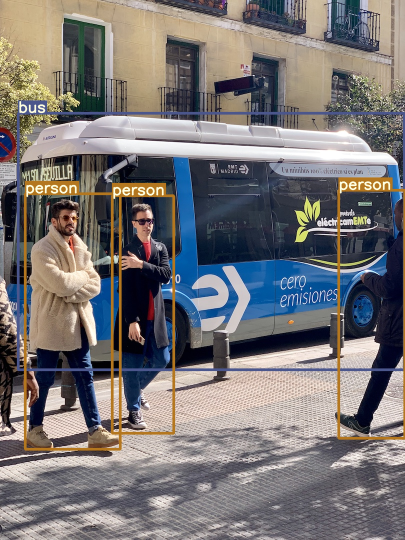

In [27]:
for box, label in zip(boxes.tolist(), labels.to(dtype=torch.int64).tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)